<a href="https://colab.research.google.com/github/GuiXu40/deeplearning0/blob/main/Basic_code/Transformer%E6%89%8B%E5%86%99%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
# step1. 构建词向量
# 关于word embedding, 以序列建模为例
# 考虑source sentence 和 target sentence
# 构建序列，序列的字符以其在词表中的索引形式出现。
# 这里随机初始化序列，在实际利用中是通过词表构建
batch_size = 2

# 词表大小
max_num_src_words = 8
max_num_tgt_words = 8 # 句子的最大长度，通过这个可以求mask矩阵
model_dim = 8

# 序列的最大长度
max_src_seq_len = 5
max_tgt_seq_len = 5
max_position_len = 5

# 初始化 src,tgt 随机序列
# src_word: (batch_size, 单词在词表中索引的位置)
src_len = torch.Tensor([2, 4]).to(torch.int32) # batch中每个句子的长度，然后构建索引
tgt_len = torch.Tensor([4, 3]).to(torch.int32)
# 随机初始化src,tgt序列，构建batch， 并padding，padding默认值为0
src_seq = torch.cat([torch.unsqueeze(F.pad(torch.randint(max_num_src_words, (L,)), (0, max(src_len) - L)), 0) for L in src_len])
#print(src_seq.shape) # [2, 4]
#print(src_seq)
tgt_seq = torch.cat([torch.unsqueeze(F.pad(torch.randint(max_num_tgt_words, (L,)), (0, max(tgt_len) - L)), 0) for L in tgt_len])
print(tgt_seq.shape) # [2, 4]
print(tgt_seq)

torch.Size([2, 4])
tensor([[2, 6, 7, 4],
        [4, 0, 1, 0]])


In [9]:
# step2. 构建word embedding
src_embedding_table = nn.Embedding(max_num_src_words+1, model_dim)
tgt_embedding_table = nn.Embedding(max_num_tgt_words+1, model_dim)
src_embedding = src_embedding_table(src_seq)
tgt_embedding = tgt_embedding_table(tgt_seq)
print(src_embedding.shape) # [2, 4, 8]
print(tgt_embedding.shape)

torch.Size([2, 4, 8])
torch.Size([2, 4, 8])


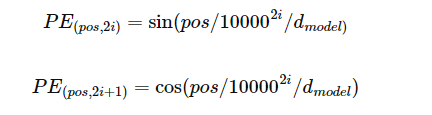

In [10]:
# step3. position embedding
pos_mat = torch.arange(max_position_len).reshape((-1, 1)) # [5, 1]
#print(pos_mat.shape)
i_mat = torch.pow(10000, torch.arange(0, 8, 2).reshape((1, -1))/model_dim)
#print(torch.arange(0, 8, 2).reshape((1, -1)))
#print(i_mat.shape) # [1, 4]
#print(i_mat)
pe_embedding_table = torch.zeros(max_position_len, model_dim) # [5, 8]
pe_embedding_table[:, 0::2] = torch.sin(pos_mat / i_mat) # 广播机制
pe_embedding_table[:, 1::2] = torch.cos(pos_mat / i_mat)

pe_embedding = nn.Embedding(max_position_len, model_dim)
pe_embedding.weight = nn.Parameter(pe_embedding_table, requires_grad=False)

src_pos = torch.cat([torch.unsqueeze(torch.arange(max(src_len)), 0) for _ in src_len]).to(torch.int32)
print(src_pos)
tgt_pos = torch.cat([torch.unsqueeze(torch.arange(max(tgt_len)), 0) for _ in tgt_len]).to(torch.int32)

src_pe_embedding = pe_embedding(src_pos)
tgt_pe_embedding = pe_embedding(tgt_pos)
print(src_pe_embedding.shape)
print(src_pe_embedding)

tensor([[0, 1, 2, 3],
        [0, 1, 2, 3]], dtype=torch.int32)
torch.Size([2, 4, 8])
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
           9.9995e-01,  1.0000e-03,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
           9.9980e-01,  2.0000e-03,  1.0000e+00],
         [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9995e-02,
           9.9955e-01,  3.0000e-03,  1.0000e+00]],

        [[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
           9.9995e-01,  1.0000e-03,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
           9.9980e-01,  2.0000e-03,  1.0000e+00],
         [ 1.4112e-01, -9.8999e-01,  

In [7]:
# step4. 构造encoder的self-attention mask
# 也就是对padding为0的值设置为-inf, 不为0的设置为1
# mask 的shape：[batch_size, max_src_len, max_src_len] 值为1或-inf
valid_encoder_pos = torch.cat([torch.unsqueeze(F.pad(torch.ones(L), (0, max(src_len) - L)), 0) for L in src_len], 0) # 有效位置
#print(valid_encoder_pos)
#print(valid_encoder_pos.shape)
valid_encoder_pos = torch.unsqueeze(valid_encoder_pos, 2)
#print(valid_encoder_pos.shape)
# 根据有效位置构建有效矩阵
valid_encoder_pos_matrix = torch.bmm(valid_encoder_pos, valid_encoder_pos.transpose(1, 2))
#print(valid_encoder_pos_matrix)

# 无效矩阵，方便做矩阵乘法
invalid_encoder_pos_matrix = 1 - valid_encoder_pos_matrix
mask_encoder_self_attention = invalid_encoder_pos_matrix.to(torch.bool)

# test
score = torch.randn(batch_size, max(src_len), max(src_len))
masked_score = score.masked_fill(mask_encoder_self_attention, -1e9)
prob = F.softmax(masked_score, -1)

print(src_len)
print(score)
print(masked_score)
print(prob)


tensor([2, 4], dtype=torch.int32)
tensor([[[-0.3556,  0.2798, -0.2408, -0.0356],
         [-1.6233, -0.9366, -0.6613, -0.1839],
         [ 0.1107, -0.0938,  0.8793, -0.8160],
         [ 1.0289, -0.9160,  0.3753,  0.5929]],

        [[ 0.3031, -1.1049,  1.9737,  0.2339],
         [ 1.1128,  0.3577,  0.0224,  0.4413],
         [ 2.0383, -0.1456,  0.5847, -1.0369],
         [-0.6189, -1.5956, -0.2806, -0.7965]]])
tensor([[[-3.5558e-01,  2.7985e-01, -1.0000e+09, -1.0000e+09],
         [-1.6233e+00, -9.3664e-01, -1.0000e+09, -1.0000e+09],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]],

        [[ 3.0310e-01, -1.1049e+00,  1.9737e+00,  2.3392e-01],
         [ 1.1128e+00,  3.5775e-01,  2.2442e-02,  4.4133e-01],
         [ 2.0383e+00, -1.4560e-01,  5.8472e-01, -1.0369e+00],
         [-6.1891e-01, -1.5956e+00, -2.8062e-01, -7.9654e-01]]])
tensor([[[0.3463, 0.6537, 0.0000, 0.0000],
         [0.3348, 0.6652, 0.0000, 0

In [30]:
# step5. intra-attention 的mask
# Q @ K^T shape: [batch_size, tgt_seq_len, src_seq_len]
valid_encoder_pos = torch.cat([torch.unsqueeze(F.pad(torch.ones(L), (0, max(src_len) - L)), 0) for L in src_len], 0) # src有效位置
valid_encoder_pos = torch.unsqueeze(valid_encoder_pos, 2)

valid_decoder_pos = torch.cat([torch.unsqueeze(F.pad(torch.ones(L), (0, max(tgt_len) - L)), 0) for L in tgt_len], 0) # tgt有效位置
valid_decoder_pos = torch.unsqueeze(valid_decoder_pos, 2)

cross_attention_pos_matrix = torch.bmm(valid_decoder_pos, valid_encoder_pos.transpose(1, 2))
print(valid_encoder_pos, valid_decoder_pos, cross_attention_pos_matrix)

invalid_cross_pos_matrix = 1 - cross_attention_pos_matrix
mask_cross_self_attention = invalid_cross_pos_matrix.to(torch.bool)
print(mask_cross_self_attention)

tensor([[[1.],
         [1.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.]]]) tensor([[[1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [0.]]]) tensor([[[1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [0., 0., 0., 0.]]])
tensor([[[False, False,  True,  True],
         [False, False,  True,  True],
         [False, False,  True,  True],
         [False, False,  True,  True]],

        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True]]])


In [32]:
# step6. 构建decoder self-attention mask
valid_decoder_tril_matrix = torch.cat([torch.unsqueeze(F.pad(torch.tril(torch.ones((L, L))), (0, max(tgt_len) - L, 0, max(tgt_len)- L)), 0) for L in tgt_len], 0)
print(valid_decoder_tril_matrix)

invalid_decoder_tril_matrix = 1 - valid_decoder_tril_matrix
mask_decoder_self_attention = invalid_decoder_tril_matrix.to(torch.bool)
print(mask_decoder_self_attention)

tensor([[[1., 0., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 1.]],

        [[1., 0., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 1., 0.],
         [0., 0., 0., 0.]]])
tensor([[[False,  True,  True,  True],
         [False, False,  True,  True],
         [False, False, False,  True],
         [False, False, False, False]],

        [[False,  True,  True,  True],
         [False, False,  True,  True],
         [False, False, False,  True],
         [ True,  True,  True,  True]]])


In [37]:
# step7. scaled_self_attention
def scaled_dot_self_attention(Q, K, V, attention_mask):
  """
  Q: [batch_size*num_head, seq_len, model_dim/num_head]
  K: [batch_size*num_head, seq_len, model_dim/num_head]
  attention_mask: [batch_size, n_heasd, seq_len, seq_len]
  """
  score = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # [batch_size x n_heads x len_q x len_k]
  print(score.shape)
  mask_score = score.masked_fill(attention_mask, -1e9)
  prob = F.softmax(mask_score, -1)
  context = torch.matmul(prob, V)
  return context, prob

In [21]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        ## 输入进来的维度分别是 [batch_size x n_heads x len_q x d_k]  K： [batch_size x n_heads x len_k x d_k]  V: [batch_size x n_heads x len_k x d_v]
        ##首先经过matmul函数得到的scores形状是 : [batch_size x n_heads x len_q x len_k]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)

        ## 然后关键词地方来了，下面这个就是用到了我们之前重点讲的attn_mask，把被mask的地方置为无限小，softmax之后基本就是0，对q的单词不起作用
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

In [35]:
# step8 mutil-head self attention layer
d_k = 2
d_v = 2
n_heads = 2
class MutilHeadAttention(nn.Module):
  def __init__(self):
    super(MutilHeadAttention, self).__init__()
    # Q, K, V 映射线性层
    self.W_Q = nn.Linear(model_dim, d_k * n_heads)
    self.W_K = nn.Linear(model_dim, d_k * n_heads)
    self.W_V = nn.Linear(model_dim, d_v * n_heads)
    self.linear = nn.Linear(n_heads * d_v, model_dim)
    self.layer_norm = nn.LayerNorm(model_dim)

  def forward(self, Q, K, V, attn_mask):
    residual, batch_size = Q, Q.size(0)

    q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
    k_s = self.W_K(Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
    v_s = self.W_V(Q).view(batch_size, -1, n_heads, d_v).transpose(1, 2)

    attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)

    context, attn = scaled_dot_self_attention(q_s, k_s, v_s, attn_mask)
    #context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
    context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
    output = self.linear(context)
    return self.layer_norm(output + residual), attn # output: [batch_size x len_q x d_model]

In [38]:
print(mask_encoder_self_attention.shape)
print(src_pe_embedding.shape)
mh = MutilHeadAttention()
output, attns = mh(src_pe_embedding, src_pe_embedding, src_pe_embedding, mask_encoder_self_attention)
print(output.shape, attns.shape)

torch.Size([2, 4, 4])
torch.Size([2, 4, 8])
torch.Size([2, 2, 4, 4])
torch.Size([2, 4, 8]) torch.Size([2, 2, 4, 4])


In [6]:
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
output1 = layer_norm(embedding)
print(output1.shape)
# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.randn(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)
print(output.shape)

torch.Size([20, 5, 10])
torch.Size([20, 5, 10, 10])
